In [28]:
import os, json
import pandas as pd
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score


In [29]:
csv_folder = "../data/testset"
fasta_folder = "../data/raw_data"
output_path = "../test/results/analysis-by-species/species_mapping.csv"
records = [] 

In [30]:
for csv_file in os.listdir(csv_folder):
    if not csv_file.endswith(".csv"):
        continue

    family_name = os.path.splitext(csv_file)[0]
    csv_path = os.path.join(csv_folder, csv_file)
    fasta_path = os.path.join(fasta_folder, f"{family_name}.fas")

    if not os.path.exists(fasta_path):
        print(f"⚠️ Skipping {family_name} — FASTA not found at {fasta_path}")
        continue

    df = pd.read_csv(csv_path)
    df["id_clean"] = df["id"].str.split("--").str[0].str.strip()

    species_map = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        header = record.description
        parts = header.split("|")
        species_name = parts[1]
        species_map[parts[0]] = species_name

    # print(species_map)
    df["species"] = df["id_clean"].map(species_map)

    df["family"] = family_name
    df["family"] = df["family"].str.replace("__", "/", regex=False)
    records.append(df[["family", "id_clean", "species"]])

In [31]:

final_df = pd.concat(records, ignore_index=True)
os.makedirs(os.path.dirname(output_path), exist_ok=True)
final_df.to_csv(output_path, index=False)

print(f"✅ Mapping complete — saved to {output_path}")
final_df.head(10)

✅ Mapping complete — saved to ../test/results/analysis-by-species/species_mapping.csv


,family,id_clean,species
0,EIL,Thhalv10001938m,Eutrema_salsugineum
1,EIL,Tp1g37880,Thellungiella_parvula
2,EIL,Pbr004574.1,Pyrus_bretschneideri
3,EIL,Sme2.5_02278.1_g00005.1,Solanum_melongena
4,EIL,ONIVA11G15950.1,Oryza_nivara
5,EIL,OBART02G21540.1,Oryza_barthii
6,EIL,Kaladp0099s0093.1.p,Kalanchoe_laxiflora
7,EIL,XP_010521603.1,Tarenaya_hassleriana
8,EIL,Rsa1.0_01679.1_g00007.1,Raphanus_sativus
9,EIL,SapurV1A.0009s0320.2.p,Salix_purpurea


In [32]:
final_df.shape

(64091, 3)

In [33]:
base_path = "../data/testset-full/k3"
mapping_path = os.path.join(base_path, "class_mapping.json")
true_label_path = os.path.join(base_path, "true_labels.csv")

In [34]:
with open(mapping_path, "r") as f:
    class_mapping = json.load(f)
true_labels = pd.read_csv(true_label_path)

final_df["family_id"] = final_df["family"].map(class_mapping)
final_df = final_df.sort_values(by="family_id").reset_index(drop=True)

if len(true_labels) == len(final_df):
    final_df["true_label"] = true_labels["true_label"]

In [35]:
final_df.tail(10)

,family,id_clean,species,family_id,true_label
64081,SAP,RrC11046_p1,Raphanus_raphanistrum,58,58
64082,SAP,Sopen05g025200.1,Solanum_pennellii,58,58
64083,SAP,Cc00_g15460,Coffea_canephora,58,58
64084,SAP,Achn384971,Actinidia_chinensis,58,58
64085,SAP,XP_016438660.1,Nicotiana_tabacum,58,58
64086,SAP,PSME_00055483-RA,Pseudotsuga_menziesii,58,58
64087,SAP,Gh_A07G2175,Gossypium_hirsutum,58,58
64088,SAP,Lus10006384,Linum_usitatissimum,58,58
64089,SAP,Solyc05g041220.1.1,Solanum_lycopersicum,58,58
64090,SAP,403897,Selaginella_moellendorffii,58,58


In [37]:
prediction = pd.read_csv("../test/results/analysis-by-species/predicted_classes_threshold.csv")
final_df["prediction"] = prediction["predicted_class"].map(class_mapping)

In [38]:
final_df.head(10)

,family,id_clean,species,family_id,true_label,prediction
0,Dof,XP_009624330.1,Nicotiana_tomentosiformis,1,1,1
1,Dof,Csa10g022470.1,Camelina_sativa,1,1,1
2,Dof,C.cajan_17965,Cajanus_cajan,1,1,1
3,Dof,EPS59263.1,Genlisea_aurea,1,1,1
4,Dof,WALNUT_00012687-RA,Juglans_regia,1,1,1
5,Dof,XP_009801284.1,Nicotiana_sylvestris,1,1,1
6,Dof,Sphfalx0003s0115.1.p,Sphagnum_fallax,1,1,1
7,Dof,Bradi1g03710.3.p,Brachypodium_distachyon,1,1,1
8,Dof,XP_016453403.1,Nicotiana_tabacum,1,1,1
9,Dof,MELO3C007704P1,Cucumis_melo,1,1,1


In [ ]:
df = final_df.copy()
final_df.shape

(64091, 7)

#### **Start analysis**

In [48]:
df["correct"] = (df["true_label"] == df["prediction"]).astype(int)
df.to_csv("./data_megaplantf.csv", index=False)

weighted_mean = (
    (df.groupby("species")["correct"].mean() * df.groupby("species")["correct"].count()).sum()
    / len(df)
)
print(f"Weighted mean accuracy across species: {weighted_mean:.4f}")

Weighted mean accuracy across species: 0.9926


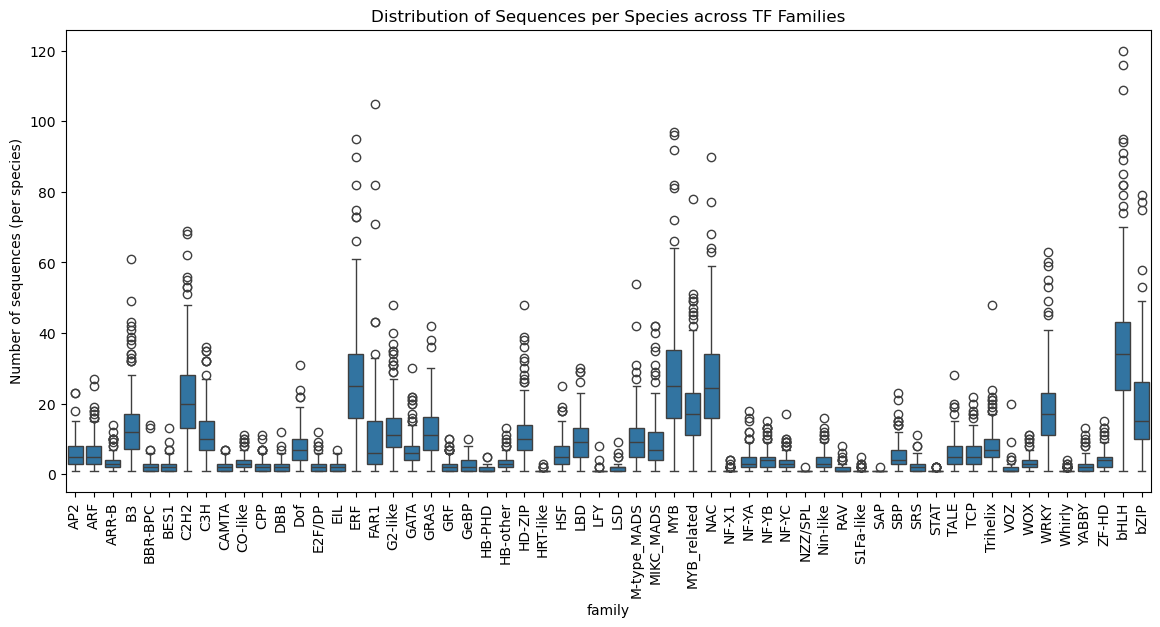

In [41]:
species_counts = (
    df.groupby(["family", "species"])
      .size()
      .reset_index(name="count")
)

plt.figure(figsize=(14, 6))
sns.boxplot(data=species_counts, x="family", y="count")
plt.xticks(rotation=90)
plt.title("Distribution of Sequences per Species across TF Families")
plt.ylabel("Number of sequences (per species)")
plt.show()


/var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T/ipykernel_68171/2283451379.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["true_label"] == x["prediction"]).mean())


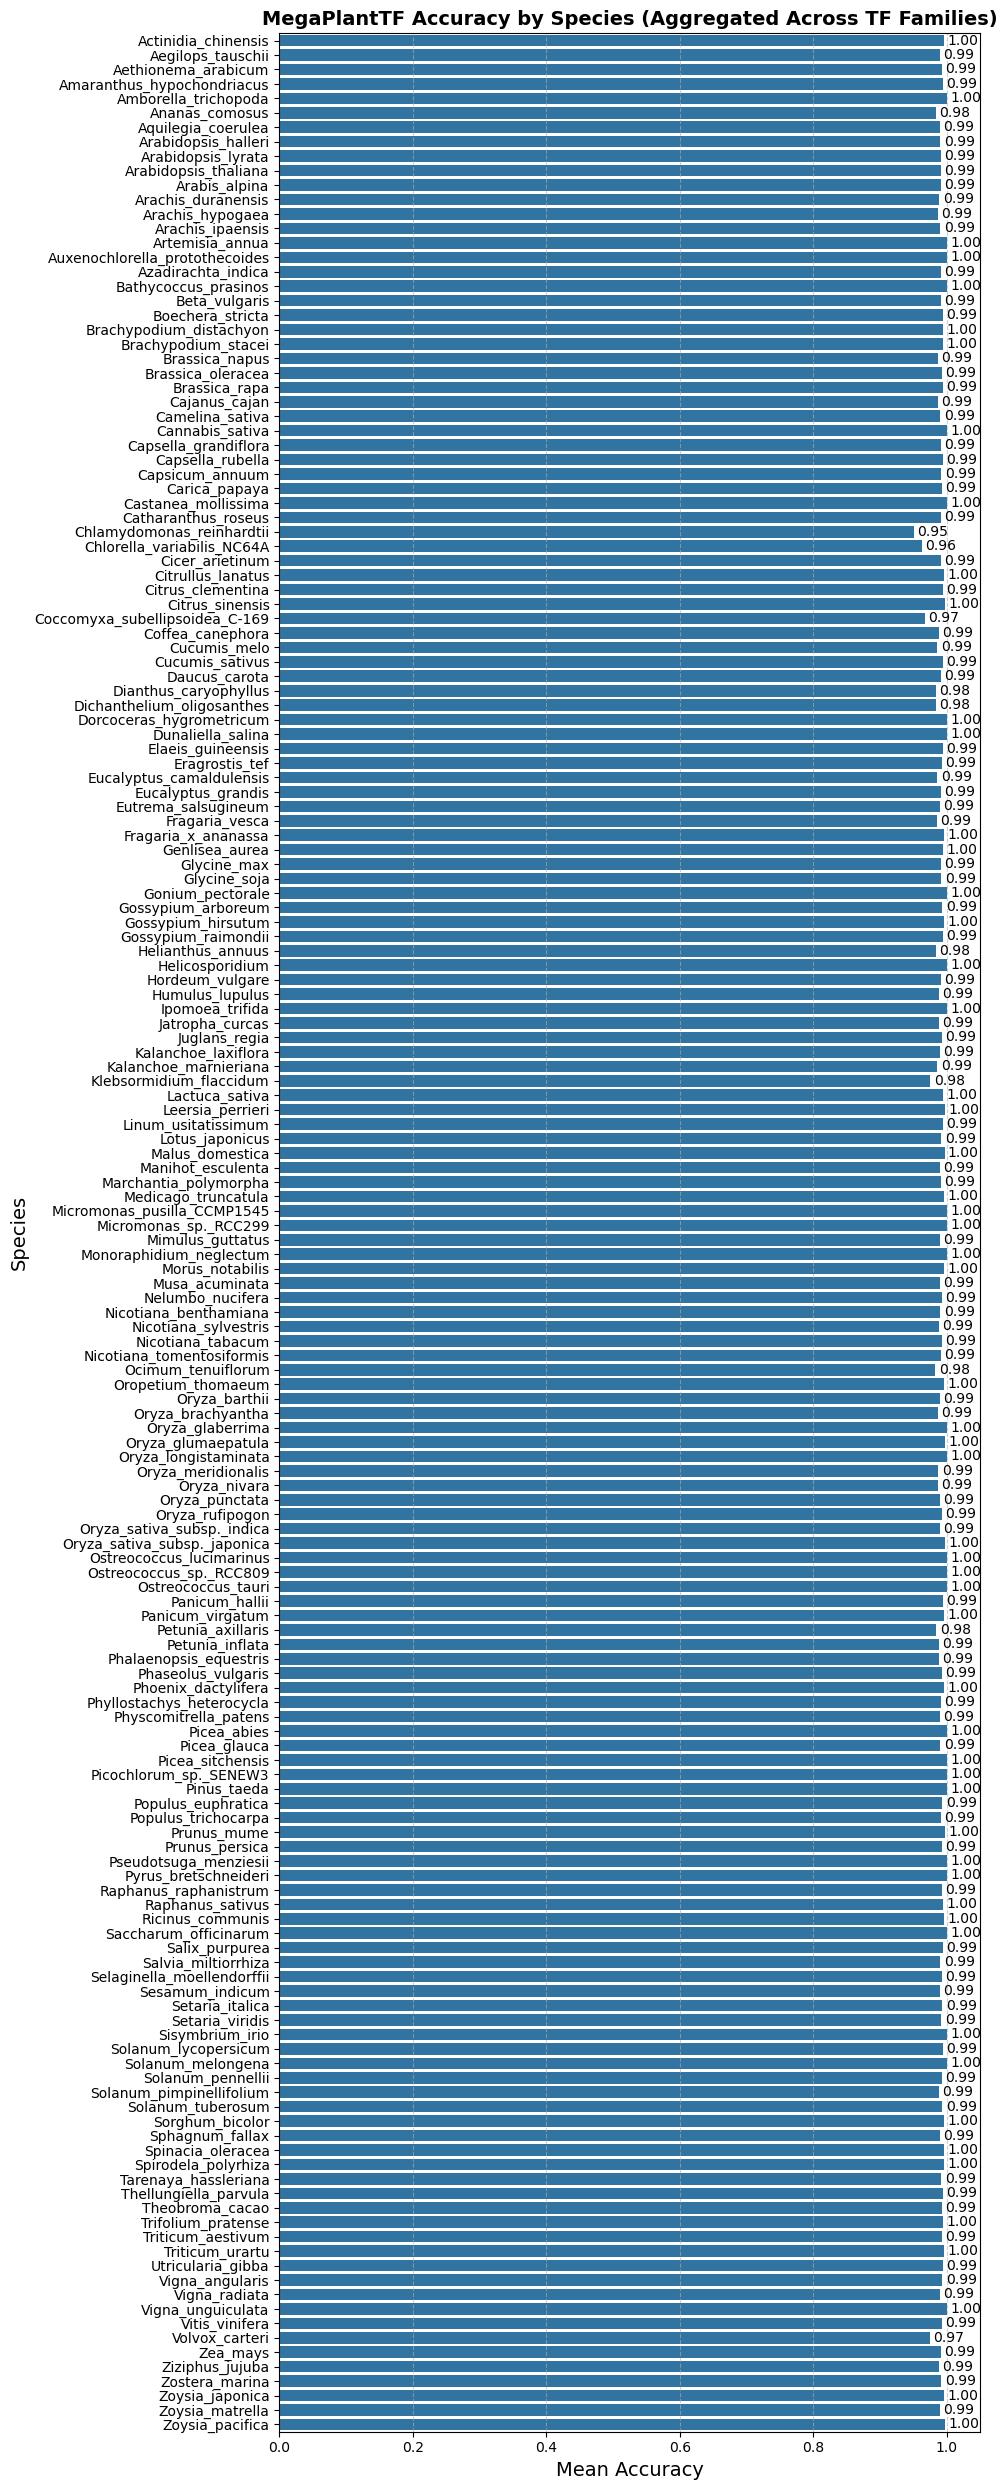

In [42]:
species_accuracy = (
    df.groupby(["species"])
      .apply(lambda x: (x["true_label"] == x["prediction"]).mean())
      .reset_index(name="accuracy")
)

plt.figure(figsize=(10, 25))
sns.barplot(
    data=species_accuracy,
    x="accuracy",
    y="species",
    # palette="viridis",
    orient="h"
)

plt.title("MegaPlantTF Accuracy by Species (Aggregated Across TF Families)", fontsize=14, weight='bold')
plt.xlabel("Mean Accuracy", fontsize=14)
plt.ylabel("Species", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
for i, (val, name) in enumerate(zip(species_accuracy["accuracy"], species_accuracy["species"])):
    plt.text(val + 0.005, i, f"{val:.2f}", va='center', fontsize=10, color='black')

plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig(
    "./species_accuracy_megaplantf.png",
    dpi=600,
    bbox_inches="tight",
    transparent=False
)
plt.show()


/var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T/ipykernel_68171/877742922.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: f1_score(x["true_label"], x["prediction"], average='macro', zero_division=0))


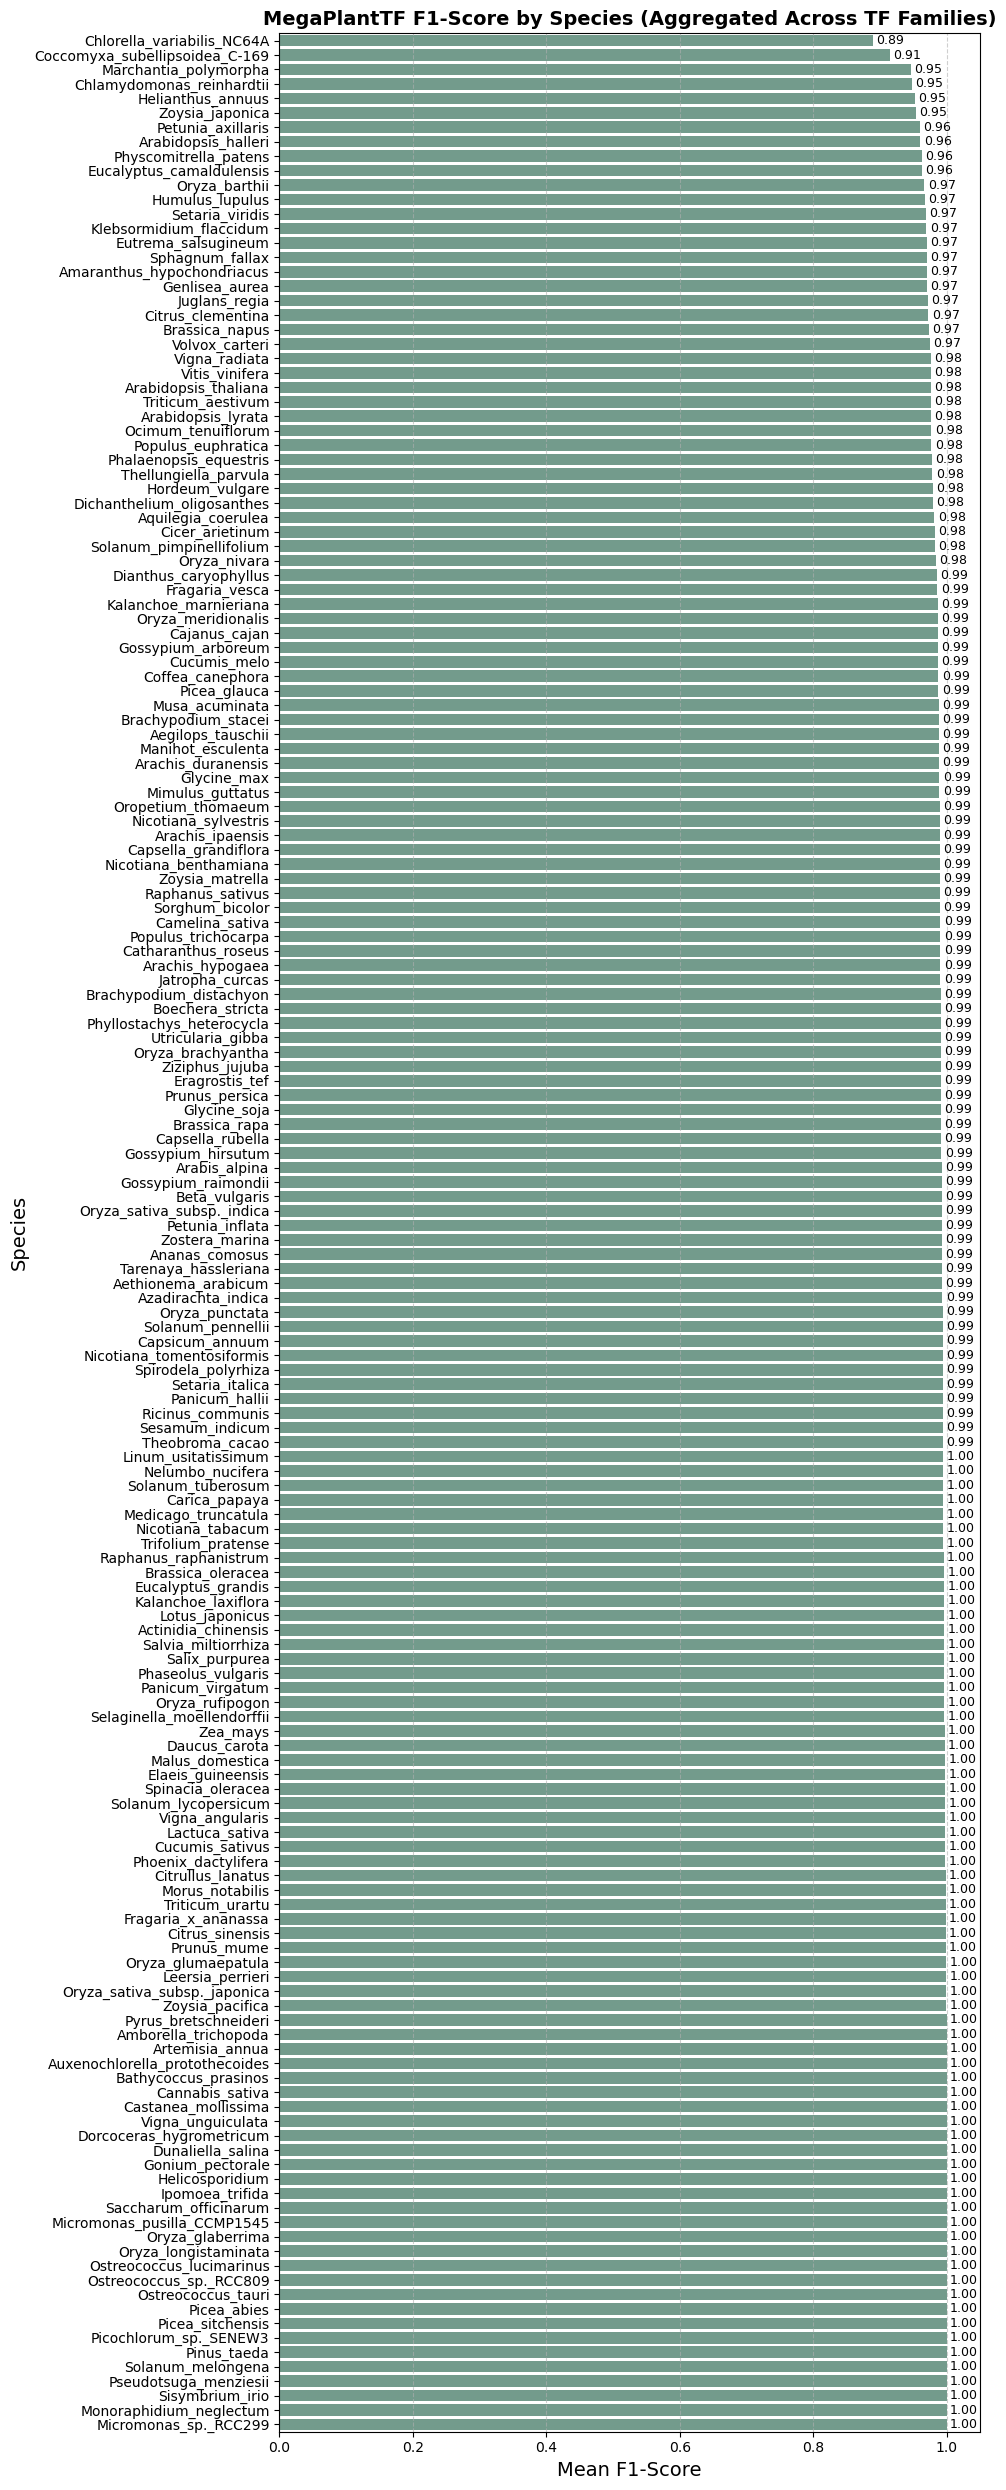

In [43]:
species_f1 = (
    df.groupby("species")
      .apply(lambda x: f1_score(x["true_label"], x["prediction"], average='macro', zero_division=0))
      .reset_index(name="f1_score")
      .sort_values("f1_score", ascending=True)
)

# Plot
plt.figure(figsize=(10, 25))
sns.barplot(
    data=species_f1,
    x="f1_score",
    y="species",
    orient="h",
    # palette="crest"
    color="#6ca28e"
)

plt.title("MegaPlantTF F1-Score by Species (Aggregated Across TF Families)", fontsize=14, weight='bold')
plt.xlabel("Mean F1-Score", fontsize=14)
plt.ylabel("Species", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate values on bars
for i, (val, name) in enumerate(zip(species_f1["f1_score"], species_f1["species"])):
    plt.text(val + 0.005, i, f"{val:.2f}", va='center', fontsize=9, color='black')

plt.xlim(0, 1.05)
plt.tight_layout()
plt.savefig(
    "./species_f1_score_megaplantf.png",
    dpi=600,
    bbox_inches="tight",
    transparent=False
)
plt.show()

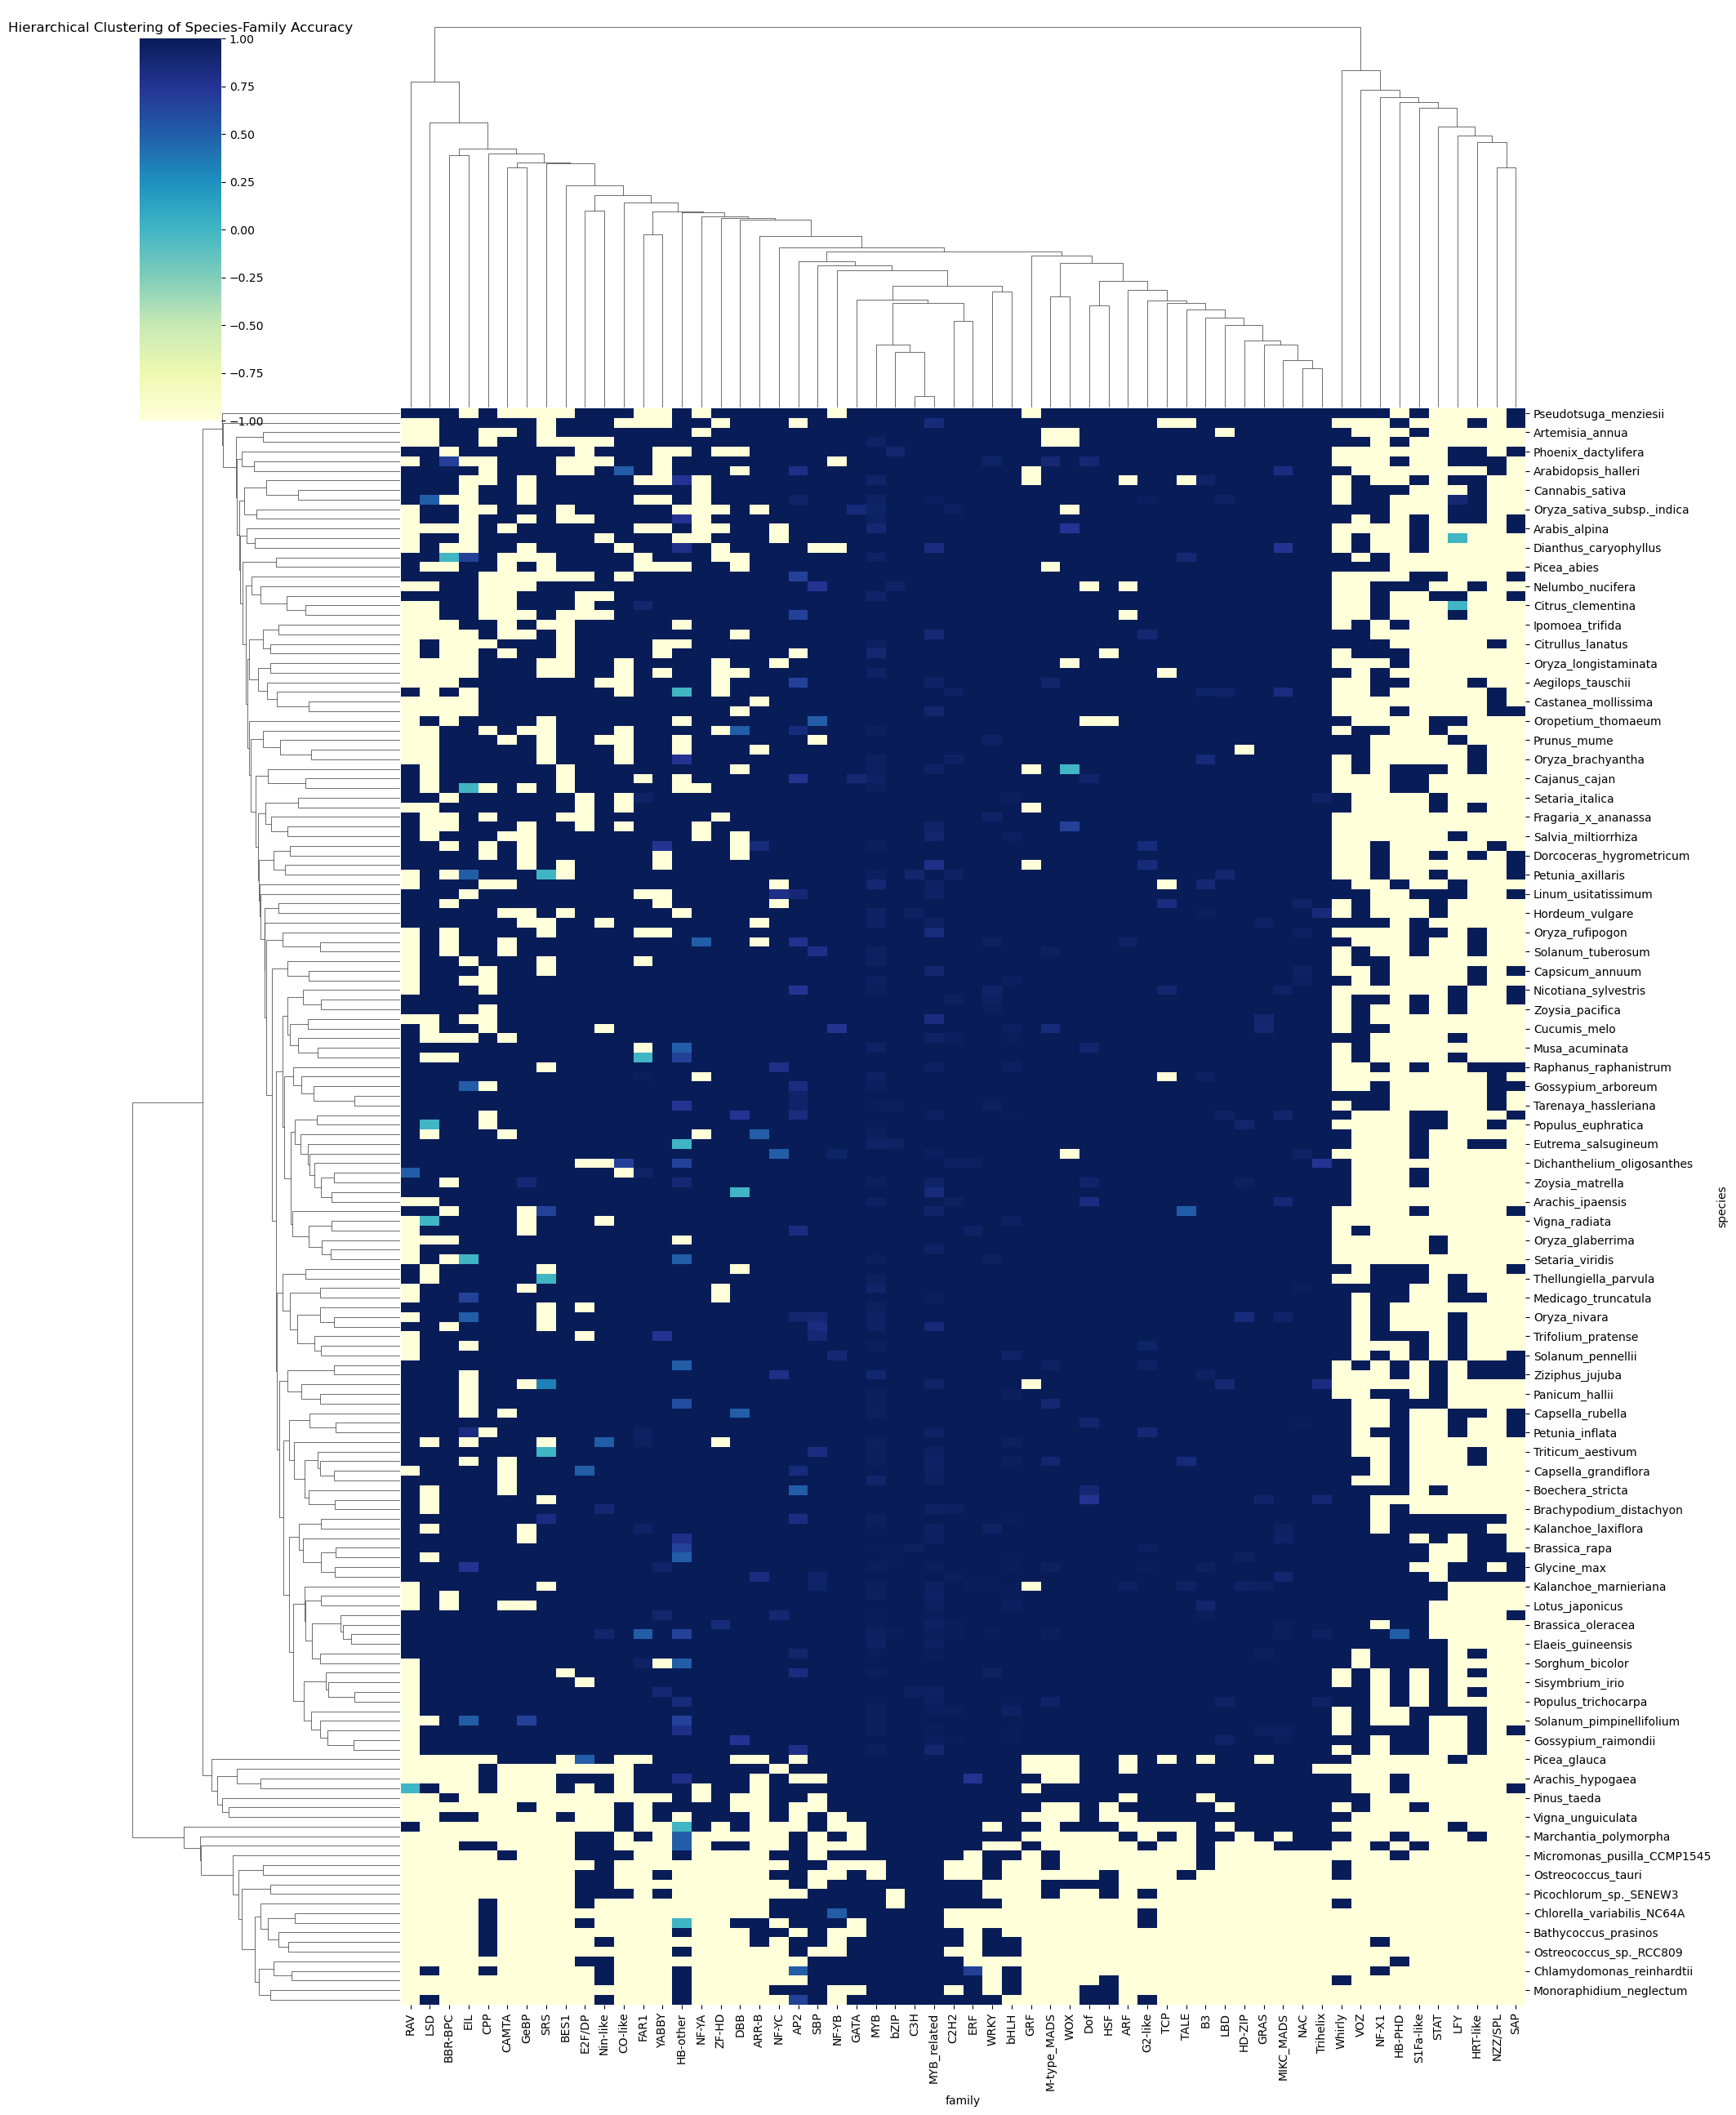

In [46]:

df = final_df
df["correct"] = (df["true_label"] == df["prediction"]).astype(int)
agg_df = (
    df.groupby(["species", "family"])
      .agg(
          accuracy=("correct", "mean"),
          count=("correct", "size")
      )
      .reset_index()
)

pivot = agg_df.pivot(index="species", columns="family", values="accuracy")
pivot_filled = pivot.fillna(-1)
sns.clustermap(pivot_filled, cmap="YlGnBu", figsize=(20,26))
plt.title("Hierarchical Clustering of Species-Family Accuracy")
plt.show()